# Impact of Music Therapy on Mental Health

**Trigger:** Music Therapy is an evidence-based practice in psychology, which uses music as a method for the production of "happy feelings". 


**Explore:** Whether there exists any correlations between the music taste / preferences of an individual and their mental health.

- Do people with specific type of mental problems have specific music taste? Is the music taste healing them or worsening the problems?
    
- For a specific type of mental health problem, which music genre should be considered for therapy?

# Data Information

- Description: 736 data points from a public mental health survey, with respondents from diverse age ranges and regions.


- Survey Structure:

    - Part 1: General background questions about the responders and their music habits.
    
    - Part 2: Frequency of listening to given music genres.
    
    - Part 3: Mental Health conditions

In [3]:
#!pip install -U kaleido
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import kaleido
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio
pio.renderers.default = "png"

## Data Screening

In [5]:
survey = pd.read_csv('mxmh_survey_results.csv')
survey.head(3) 

,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,156.0,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,119.0,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,132.0,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.


In [6]:
# data shape
survey.shape

(736, 32)

In [7]:
# check columns
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           735 non-null    float64
 1   Primary streaming service     735 non-null    object 
 2   Hours per day                 736 non-null    float64
 3   While working                 733 non-null    object 
 4   Instrumentalist               732 non-null    object 
 5   Composer                      735 non-null    object 
 6   Fav genre                     736 non-null    object 
 7   Exploratory                   736 non-null    object 
 8   Foreign languages             732 non-null    object 
 9   BPM                           629 non-null    float64
 10  Frequency [Classical]         736 non-null    object 
 11  Frequency [Country]           736 non-null    object 
 12  Frequency [EDM]               736 non-null    object 
 13  Frequ

## Clean Missing Values & Data Imputation

In [9]:
# check missing values: True 1, False 0
survey.isnull().sum()

Age                               1
Primary streaming service         1
Hours per day                     0
While working                     3
Instrumentalist                   4
Composer                          1
Fav genre                         0
Exploratory                       0
Foreign languages                 4
BPM                             107
Frequency [Classical]             0
Frequency [Country]               0
Frequency [EDM]                   0
Frequency [Folk]                  0
Frequency [Gospel]                0
Frequency [Hip hop]               0
Frequency [Jazz]                  0
Frequency [K pop]                 0
Frequency [Latin]                 0
Frequency [Lofi]                  0
Frequency [Metal]                 0
Frequency [Pop]                   0
Frequency [R&B]                   0
Frequency [Rap]                   0
Frequency [Rock]                  0
Frequency [Video game music]      0
Anxiety                           0
Depression                  

In [10]:
'''1. Age imputation (numeric) --> fill in with column mean'''
age_mean = round(survey['Age'].mean())
survey['Age'] = survey['Age'].fillna(age_mean)

'''2. Primary streaming service (categorical) --> fill with mode'''
service_mode = survey['Primary streaming service'].mode()[0] #index
survey['Primary streaming service'] = survey['Primary streaming service'].fillna(service_mode)

'''3. While working (categorical) --> fill with mode'''
work_mode = survey['While working'].mode()[0]
survey['While working'] = survey['While working'].fillna(work_mode)

'''4. Instrumentalist --> mode'''
inst_mode = survey['Instrumentalist'].mode()[0]
survey['Instrumentalist'] = survey['Instrumentalist'].fillna(inst_mode)

'''5. Composer --> mode'''
comp_mode = survey['Composer'].mode()[0]
survey['Composer'] = survey['Composer'].fillna(comp_mode)

'''6. Foreign languages --> mode'''
lang_mode = survey['Foreign languages'].mode()[0]
survey['Foreign languages'] = survey['Foreign languages'].fillna(lang_mode)

- Problem:

    "Music effects" is the major "Response" Variable, which can't be replaced by values from other people
    

- Solution:

    Define a NEW LABEL **"Uncertain"** for missing responses

In [12]:
# check unique values of a column
survey['Music effects'].unique()

'''7. Music effects --> new label'''
survey['Music effects'] = survey['Music effects'].fillna('Uncertain')
# survey.isnull().sum()

- Problem:
    
    BPM (beats per minute) is an optional question in the survey, so 107 out 736 missing. As the percentage is quite high, column mean can't be used here.
    

- Solution:

    Music of same genres would have similar BPM range, so we can **calculate the average BPM for each genre**, and fill in NA based on the given genre in that row.

In [14]:
# rows with BPM missing
bpm_na = survey[survey['BPM'].isna()]
# which genres of bpm to check?
bpm_na_genre = list(bpm_na['Fav genre'].unique())

### Remove Outliers in BPM

In [16]:
# replace outlier with 0
'''
1. find and drop LARGE outliers first, then add back
'''
# add back
bpm_out1 = survey[survey['BPM']>=500]
# drop LARGE outlier rows
bpm_index1 = survey[survey['BPM']>=500].index
survey = survey.drop(bpm_index1, axis=0)

'''
2. find and drop SMALL outliers first, then add back
'''
# add back
bpm_out2 = survey[survey['BPM']==0]
# drop 0 outlier rows
bpm_index2 = survey[survey['BPM']==0].index
survey = survey.drop(bpm_index2, axis=0)

In [17]:
'''Generate a dictionary to MAP genres and its BPM'''
bpm_dict = {}

for index, row in survey.iterrows():
    genre = row['Fav genre']  
    bpm = row['BPM']        
    
    if pd.notna(bpm):  
        if genre not in bpm_dict:
            bpm_dict[genre] = {'total_bpm': 0, 'count': 0} 
        bpm_dict[genre]['total_bpm'] += bpm
        bpm_dict[genre]['count'] += 1
mean_bpm = {genre: round(data['total_bpm']/data['count'], 1) for genre, data in bpm_dict.items()}

In [18]:
'''8. BPM --> fill in NA with genre mean'''
survey['BPM'] = survey['BPM'].fillna(survey['Fav genre'].map(mean_bpm))
bpm_out1.loc[bpm_out1['BPM']>500, 'BPM'] = bpm_out1['Fav genre'].map(mean_bpm)
bpm_out2.loc[bpm_out2['BPM']==0, 'BPM'] = bpm_out2['Fav genre'].map(mean_bpm)
survey = pd.concat([survey, bpm_out1, bpm_out2], axis=0)
# reset index
survey = survey.reset_index(drop=True)

## Explore Variable Distributions

## 1. Age

In [21]:
# descriptive statistics
survey['Age'].describe() 

count    736.000000
mean      25.206522
std       12.046769
min       10.000000
25%       18.000000
50%       21.000000
75%       28.000000
max       89.000000
Name: Age, dtype: float64

### Findings:

1. Most of the survey audience are young people with age ranging from 10 to 28

2. 75% (3rd quartile) and max has a huge gap, which indicates the existence of outlier

Distribution: Left Skewness (Right-tailed)

#### Outlier Detection: Age > 75

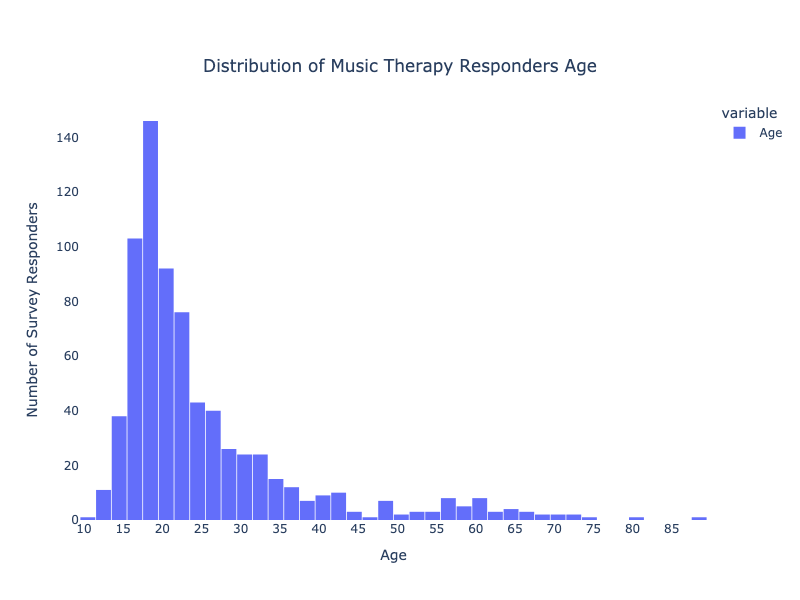

In [23]:
'''Check Age Distribution'''
fig = px.histogram(survey['Age'], 
                   # number of bins
                   nbins=40, 
                   title="Distribution of Music Therapy Responders Age")


fig.update_layout(
    width=800, height=600,
    bargap=0.05, 
    title_x=0.5, 
    title_y=0.9,
    font=dict(size=12),
    xaxis_title='Age', yaxis_title='Number of Survey Responders',
    # set x ticks: tick values
    xaxis=dict(tickvals=list(range(10, 90, 5))),
    plot_bgcolor='white'
)

fig.show('png')

### Drop AGE outliers > 75

In [25]:
Age_index1 = survey[survey['Age']>75].index
survey = survey.drop(Age_index1, axis=0)
# reset index
survey = survey.reset_index(drop=True)

### Findings:

People in age group of 14-35 listen to music more frequently.

## 2. Hours per day

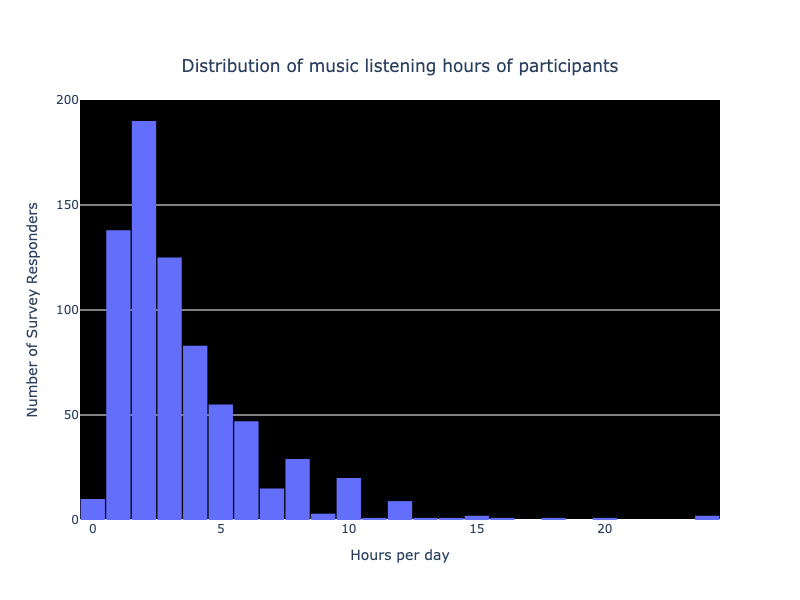

In [28]:
fig = px.histogram(survey['Hours per day'], 
                   nbins=40, 
                   title="Distribution of music listening hours of participants")

fig.update_layout(
    bargap=0.05, 
    title_x=0.5, 
    title_y=0.9,
    font=dict(size=12),
    xaxis_title='Hours per day', yaxis_title='Number of Survey Responders',
    xaxis=dict(tickvals=list(range(0, 100, 5))),
    plot_bgcolor='black',
    height=600, width=800, showlegend = False
)

fig.show('png')

In [29]:
'''Remove outliers in Hours (clean >12)'''
hour_out = survey[survey['Hours per day']>12].index
survey = survey.drop(hour_out, axis=0)

# reset index
survey = survey.reset_index(drop=True)

### Findings:

Most people listen to music about 1-5 hours per day.

## 3. Primary Streaming Service

In [32]:
service_count = survey['Primary streaming service'].value_counts()
service_count

Primary streaming service
Spotify                              451
YouTube Music                         93
I do not use a streaming service.     70
Apple Music                           50
Other streaming service               50
Pandora                               11
Name: count, dtype: int64

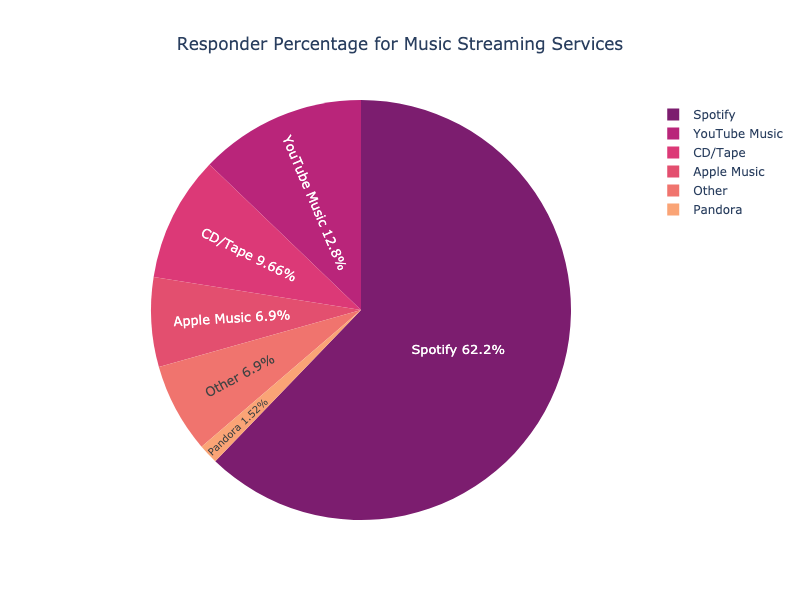

In [33]:
'''Interactive Pie Chart'''
service_name=['Spotify', 'YouTube Music', 'CD/Tape', 'Apple Music', 'Other', 'Pandora']
fig3 = px.pie(service_count, 
              values=service_count.values, 
              names=service_name, #service_count.index,
              title='Responder Percentage for Music Streaming Services', 
              color_discrete_sequence=px.colors.sequential.Sunsetdark_r
             )

fig3.update_traces(
    textinfo="percent+label",
    textposition='inside',
    textfont_size=13,
    texttemplate="%{label} %{percent}"
)

fig3.update_layout(title_x=0.5, width=800,height=600)
fig3.show('png')

### Findings:

**Spotify** is clearly the most popular streaming service. (more than half population)

## 4. While Working

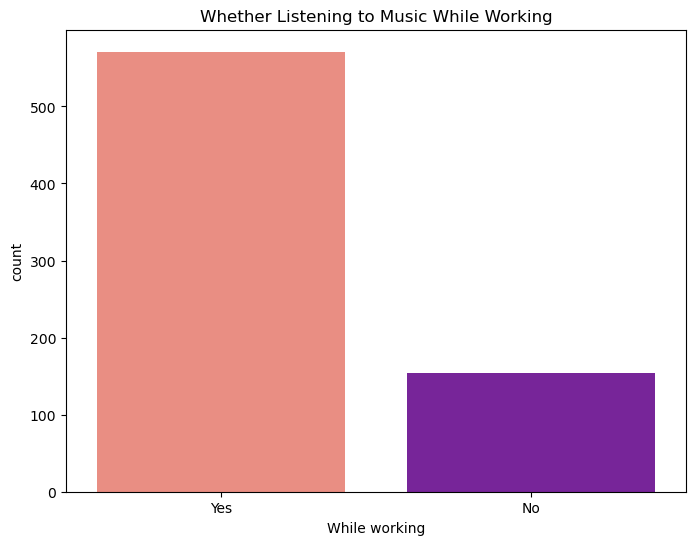

In [36]:
survey['While working'].value_counts(normalize=True)

'''seaborn countplot: used for comparing between groups'''
# set size
plt.figure(figsize=(8, 6))

sns.countplot(x=survey['While working'], 
              palette=['salmon', '#7F12AC'])

plt.title('Whether Listening to Music While Working')
plt.show()

### Findings:

79% of the responders listen to music while working.

## 5&6 Instrumentalist & Composer

In [39]:
survey['Instrumentalist'].value_counts()

Instrumentalist
No     493
Yes    232
Name: count, dtype: int64

In [40]:
survey['Composer'].value_counts()

Composer
No     602
Yes    123
Name: count, dtype: int64

### Feature Engineering: 'Pro'

Generate a new feature by combining existed columns, based on condition

In [42]:
survey['Pro_temp'] = np.where((survey['Instrumentalist']=='Yes') | 
                              (survey['Composer']=='Yes'), 
                              'Yes', 'No')
'''Insert a new column at a specific column'''
survey.insert(4, 'Pro', survey['Pro_temp'])
'''DROP redundant columns: Ins, Comp, Pro_temp, Permissions'''
survey = survey.drop(columns=['Instrumentalist', 'Composer', 'Pro_temp', 'Permissions'], 
                     axis=1)

In [43]:
survey['Pro'].value_counts(normalize=True)

Pro
No     0.634483
Yes    0.365517
Name: proportion, dtype: float64

### Findings:

**36.55%** of the responders have **professional** music experience in playing instruments or composing.

## 7. Favorite genre

In [46]:
genre_count = survey['Fav genre'].value_counts()

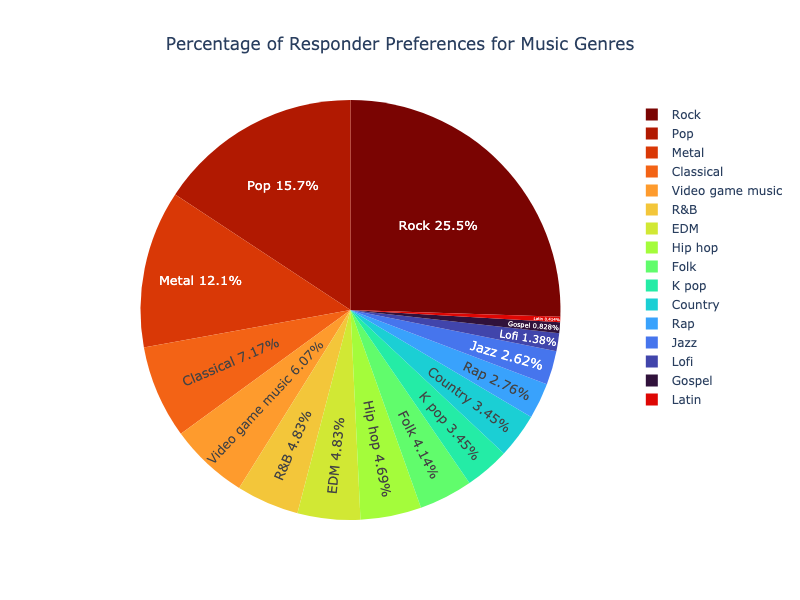

In [47]:
'''Interactive Pie Chart'''
fig4 = px.pie(survey,        
              values=genre_count.values, 
              names=genre_count.index, #service_count.index,
              title='Percentage of Responder Preferences for Music Genres', 
              color_discrete_sequence=px.colors.sequential.Turbo_r
             )

fig4.update_traces(
    textinfo="percent+label",
    textposition='inside',
    textfont_size=13,
    texttemplate="%{label} %{percent}"
)

fig4.update_layout(title_x=0.5, width=800, height=600)

fig4.show('png')

### Findings:

1. Top 3 favorite genres among responders are **Rock (25.5%), Pop (15.7%) and Metal (12.1%)**, these 3 genres already occupies >50% population's preferences.

2. As we already know that responder in this survey are mostly 14-35 year-old young people, so different music genres might attract their own age groups.

## Bivariate Analysis on "Favorite Genre" and "Age"

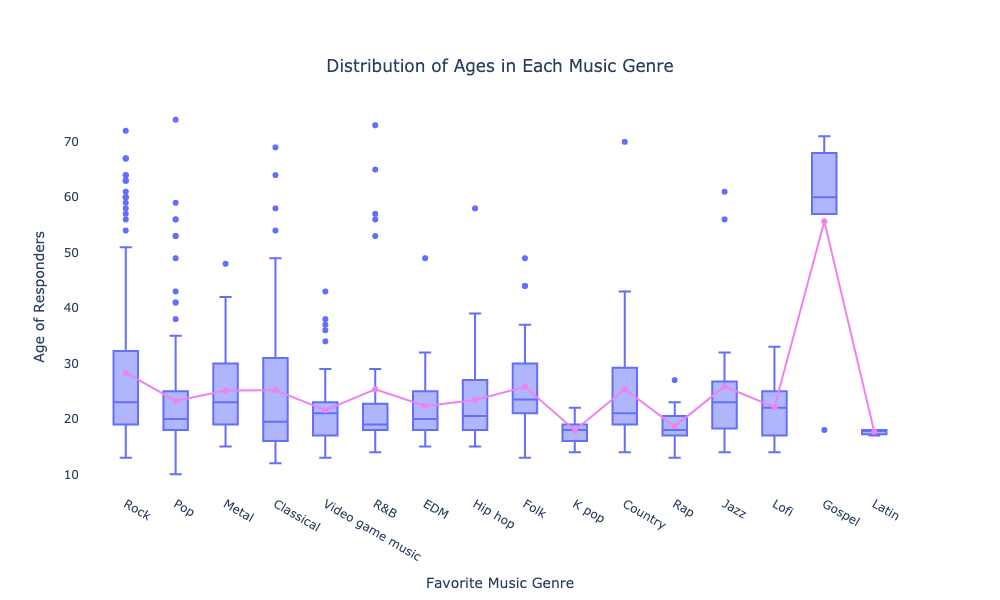

In [50]:
'''For each music genre, check the age distribution'''
fig5 = px.box(x=survey['Fav genre'], y=survey['Age'], 
              orientation='v', points='outliers',
              notched=False,
              title='Distribution of Ages in Each Music Genre'
             )

fig5.update_traces(boxmean=False)

fig5.update_layout(
    width=1000, height=600,
    title_x=0.5, title_y=0.9,
    xaxis_title='Favorite Music Genre',
    yaxis_title='Age of Responders',
    plot_bgcolor='white',
    showlegend=False
)
fig5.update_xaxes(categoryorder='array', categoryarray=genre_count.index)
age_mean = dict(survey.groupby(survey['Fav genre'])['Age'].mean())
agemean_by_genre = {}
for i in genre_count.index:
    agemean_by_genre[i] = age_mean[i] # key: value
    
fig5.add_trace(
    # graph object
    go.Scatter(x=list(agemean_by_genre.keys()), 
               y=list(agemean_by_genre.values()),
               mode='lines+markers', name='Mean Age', 
               marker=dict(color='violet'))
    )

fig5.show('png')

In [51]:
age_mean = dict(survey.groupby(survey['Fav genre'])['Age'].mean())
agemean_by_genre = {}
for i in genre_count.index:
    agemean_by_genre[i] = age_mean[i] # key: value

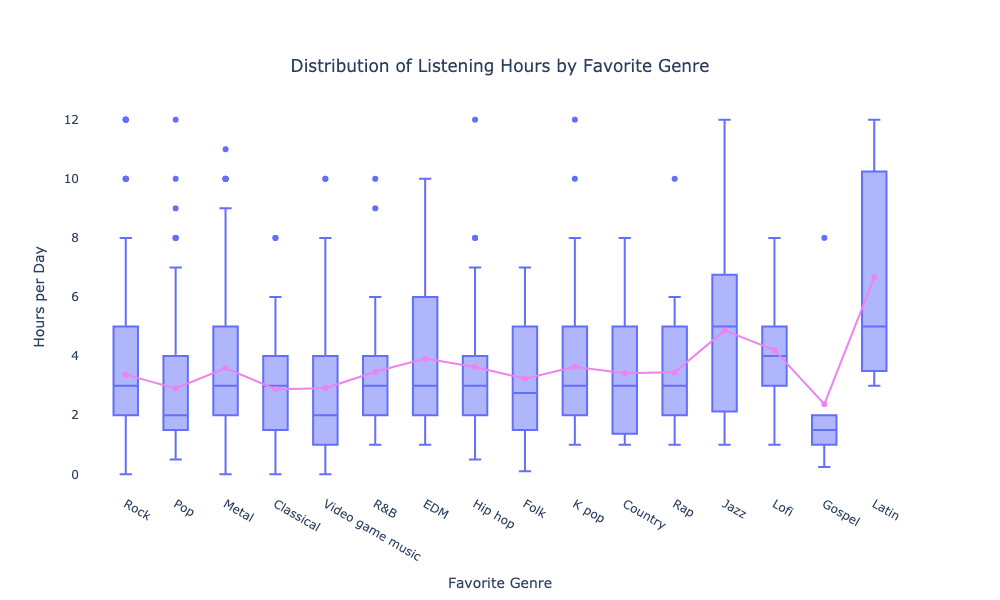

In [52]:
'''Distribution of Listening Hours by Favorite Genre'''
fig6 = px.box(survey, x='Fav genre', y='Hours per day',
                  title='Distribution of Listening Hours by Favorite Genre',
                  labels={'Fav genre': 'Favorite Genre', 'Hours per day': 'Hours per Day'}
)
fig6.update_traces(boxmean=False)

fig6.update_layout(
    width=1000, height=600,
    title_x=0.5, title_y=0.9,
    plot_bgcolor='white',
    showlegend=False
)

fig6.update_xaxes(categoryorder='array', categoryarray=genre_count.index)

LH_mean = dict(survey.groupby(survey['Fav genre'])['Hours per day'].mean())
LHmean_by_genre = {}

for i in genre_count.index:
    LHmean_by_genre[i] = LH_mean[i] 
    
fig6.add_trace(
    go.Scatter(x=list(LHmean_by_genre.keys()), 
               y=list(LHmean_by_genre.values()),
               mode='lines+markers', name='Mean Hours', 
               marker=dict(color='violet')
              ))

fig6.show('png')

### Findings:

1. **Latin shows a significantly long** listening time with 75% people who like this genre best listen to Latin for 3.5+ hours (median=5hr).


2. **Gospel shows the smallest range of listening hours**, with most of people in this group listening to Gospel music for less than 2 hours. 

## 8&9 Exploratory & Foreign languages

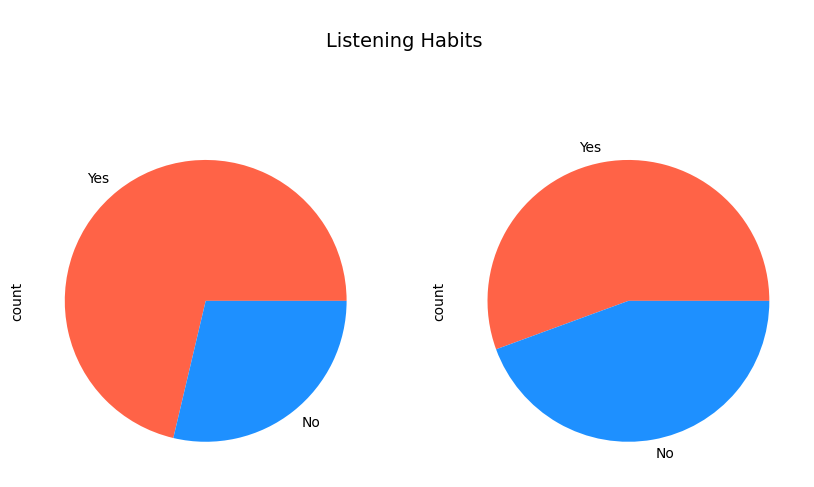

In [55]:
'''SUBPLOT'''
fig7 = plt.figure(figsize=(10, 6))
# super title
plt.suptitle('\nListening Habits', fontsize=14)

ax = fig7.add_subplot(1, 2, 1)
explore = survey['Exploratory'].value_counts()
explore.plot(kind='pie', colors=['tomato', 'dodgerblue'])

ax = fig7.add_subplot(1, 2, 2)
foreign = survey['Foreign languages'].value_counts()
foreign.plot(kind='pie', colors=['tomato', 'dodgerblue'])

fig7.show()

## Listening Frequency for Each Genre

- Cleaning: Convert words into numbers

In [57]:
survey = survey.replace(['Never', 'Rarely', 'Sometimes', 'Very frequently'], 
                        [0, 1, 2, 3])

In [58]:
'''Calculate number of people in each frequency group by genre'''
gen_freq_dict = {}

for i in range(9, 25):
    genre_name = survey.iloc[:, i].name[11:-1]
    genre_freq = survey.iloc[:,i].value_counts().sort_index()
    gen_freq_dict[genre_name] = genre_freq.values.tolist()

'''Create a DataFrame based on a Dictionary'''
gen_freq_df = pd.DataFrame(gen_freq_dict, columns=gen_freq_dict.keys())
# clarify our own freq LABEL: 0123 (not auto index)
gen_freq_df.index = [0, 1, 2, 3]

'''Transpose data, to make genre a new variable'''
gen_freq_df = gen_freq_df.T.reset_index()
gen_freq_df.columns = ['genre', 'Never', 'Rarely', 'Sometimes','VeryFrequently']

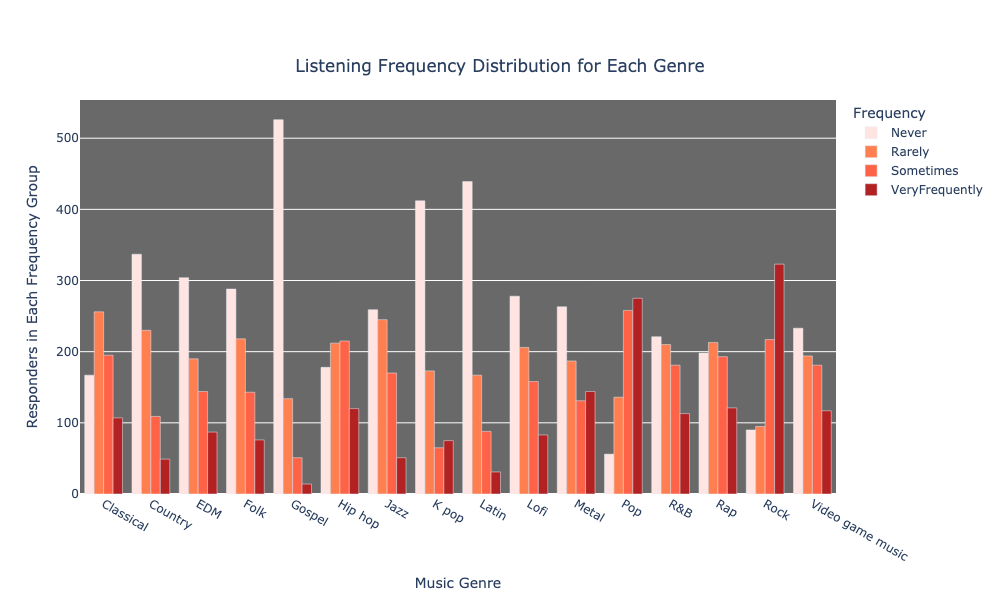

In [59]:
fig10 = px.bar(gen_freq_df, 
               x='genre', 
               y=['Never', 'Rarely', 'Sometimes', 'VeryFrequently'], 
               barmode='group', 
               title='Listening Frequency Distribution for Each Genre', 
               labels={'variable': 'Frequency'},
               color_discrete_sequence=['mistyrose', 'coral', 'tomato', 'firebrick']
              )
fig10.update_layout(
    width=1000, height=600,
    title_x=0.5, title_y=0.9,
    # xlabel
    xaxis_title='Music Genre', yaxis_title='Responders in Each Frequency Group',
    plot_bgcolor='dimgrey'
)
fig10.show('png')

### Findings:

1. Genres with most responders who **"Never"** listen to them: Gospel, Latin, K Pop

2. Genres with fans who listen **Very Frequently**: Rock and Pop

## 10. Explore the Mental Problems of the Responders

In [62]:
mental_problem = survey[['Anxiety', 'Depression', 'Insomnia', 'OCD']]
mental_problem.sample(3)

,Anxiety,Depression,Insomnia,OCD
683,2.0,0.0,0.0,2.0
641,7.0,10.0,0.0,8.0
515,8.0,7.0,10.0,6.0


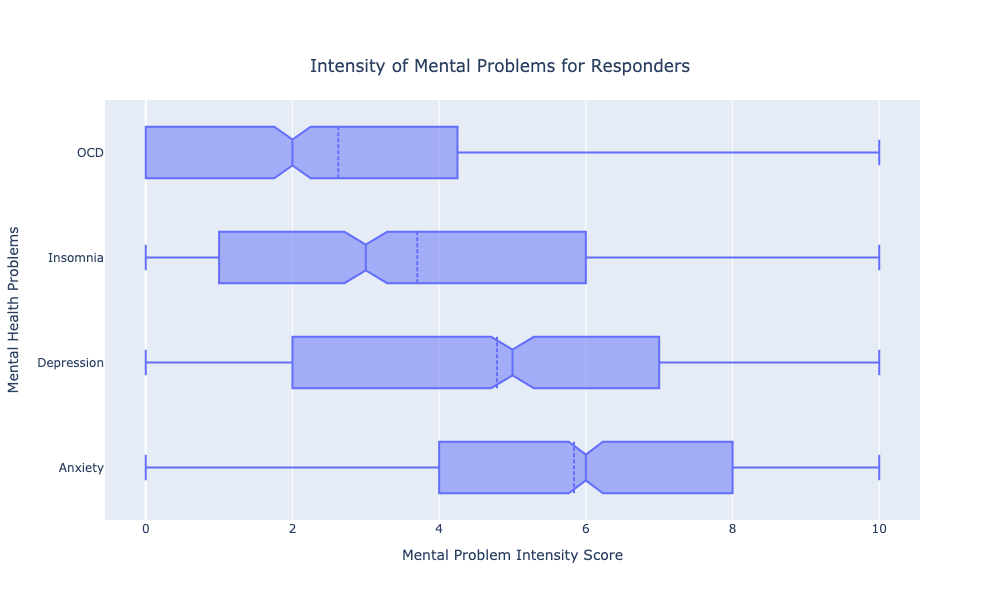

In [63]:
fig11 = px.box(mental_problem, 
               orientation='h', 
               notched=True,
               title='Intensity of Mental Problems for Responders'
              )
fig11.update_traces(boxmean=True)
fig11.update_layout(
    width=1000, height=600,
    title_x=0.5, title_y=0.9,
    xaxis_title='Mental Problem Intensity Score', yaxis_title='Mental Health Problems',
)
fig11.show('png')

### Findings:

<u/>Define the Levels of mental problems: **Level 1-3 (Mild), Level 4-7 (Moderate), Level 8-10 (Severe)**</u>

1. OCD seems to be the **least serious** mental problem among responders, with **a mean at Level 2.6 (Mild), and Q3 75% are below Level 4.25 (Mild~Moderate)**.


2. Insomnia is **somewhat common** among responders, with median at Level 3 (Mild), and Q3 at Level 6 (Moderate). 


3. Depression is **relatively common** among responders, with intensity scores are quite **evenly distributed**, with **median at Level 5**. 



4. Anxiety is the **most serious** problem among responders, where 50% people with intensity score above Level 6, Q1 at Level 4, and **Q3 at Level 8**. 

## Mental Health Problems across Genre

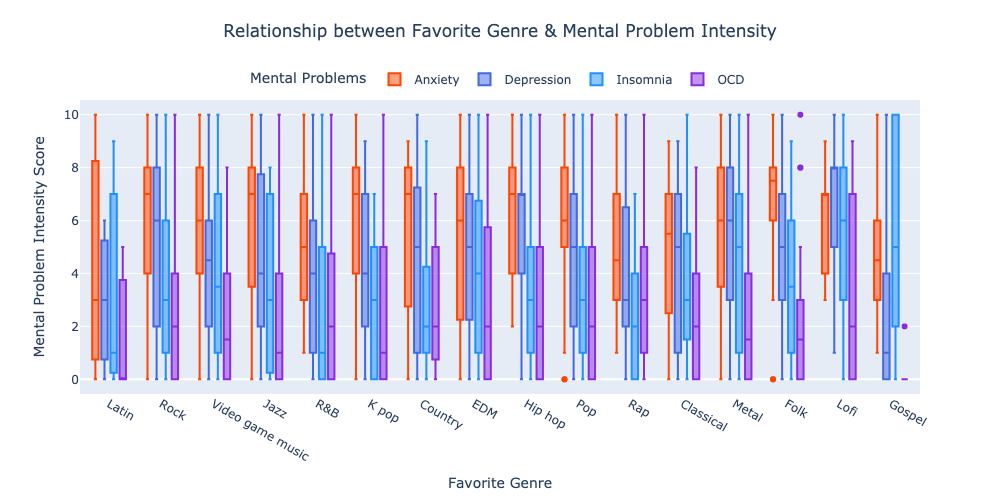

In [66]:
mh_genre = survey[['Anxiety', 'Depression', 'Insomnia', 'OCD', 'Fav genre']]
fig11 = go.Figure()

# Anxiety
fig11.add_trace(
    go.Box(
        x=mh_genre['Fav genre'],
        y=mh_genre['Anxiety'],
        marker_color='orangered',
        name='Anxiety')
)

# Depression
fig11.add_trace(
    go.Box(
        x=mh_genre['Fav genre'],
        y=mh_genre['Depression'],
        marker_color='royalblue',
        name='Depression')
)

# Insomnia
fig11.add_trace(
    go.Box(
        x=mh_genre['Fav genre'],
        y=mh_genre['Insomnia'],
        marker_color='dodgerblue',
        name='Insomnia')
)

# OCD
fig11.add_trace(
    go.Box(
        x=mh_genre['Fav genre'],
        y=mh_genre['OCD'],
        marker_color='blueviolet',
        name='OCD')
)

fig11.update_layout(
    width=1000, height=500,
    boxmode='group',
    xaxis_title='Favorite Genre',
    yaxis_title='Mental Problem Intensity Score',
    title_text='Relationship between Favorite Genre & Mental Problem Intensity',
    title_x=0.5, title_y=0.95,
    legend=dict(title='Mental Problems', xanchor='left', x=0.2, yanchor='top', y=1.12, orientation='h')
)

fig11.show('png')

## Compare Among Mental Problems

1. **Anxiety**

    - Responders who favor **Folk** have obviously higher intensity of anxiety, with <u/>**almost all above Level 3** (except one outlier at 0), **75% above Level 6 and median at Level 7.5**</u>
    
    - **Pop** listeners have comparatively higher anxiety level, with 75% above Level 5
    
    - **Hip hop** (all above Level 2, median at Level 7) and **Lofi** (with all above Level 3, median at Level 7) listeners have higher anxiety level.
    
    - Responders who listen to **Gospel** are **less likely to have anxiety**, where 75% are below Level 6 (moderate)
    
    
2. **Depression**

    - Responders who listen to **lofi** show the greatest propensity to suffer from **depression**, <u/>with 25% above level 8 and 75% above level 5.</u>
    
    - Responders who listen to **latin** and **gospel** exhibit significantly less level of depression, <u/>with 50% of those who listen to gospel have depression level below 1 and 50% of those who listen to latin have a depression level of 3. </u>
  
  
3. **Insomnia**

    - Responders who listen to **lofi** also show a high level of insomnia, <u/>with a median at level 6 and 25% above level 8. </u>
    
    - **Video game music**(median at level 3.5, 25% above level 7), and **metal**(median at level 5 and 25% above level 7)
    
    - Responders who listen to **rap** generally have **lower intensity of insomnia**, with <u/>100% below Level 7 and 75% below Level 4</u>


4. **OCD**

    - Responders who listen to **rap** show a relatively high level of OCD, <u/>with a median at level 3 and 75% above level 1. </u>
    
    - Responders who listen to **folk** generally have **lower intensity of OCD**, <u/>with 90%+ below Level 5 and median at Level 1.5.</u>


## Overview Among Genres

- Overall, responders who listen to **lofi** have high levels in all four mental problems, **especially in depression and insomnia**. 

- Generally, responders who listen to **R&B and Rap** have relatively lower levels in alll four mental problems, <u/>with all medians below Level 5.</u>

In [68]:
# Level 8-10
anxiety_high = survey[survey['Anxiety']>=8]['Hours per day'].mean()
depression_high = survey[survey['Depression']>=8]['Hours per day'].mean()
insomnia_high = survey[survey['Insomnia']>=8]['Hours per day'].mean()
ocd_high = survey[survey['OCD']>=8]['Hours per day'].mean()

# Level 1-3
anxiety_low = survey[survey['Anxiety']<=3]['Hours per day'].mean()
depression_low = survey[survey['Depression']<=3]['Hours per day'].mean()
insomnia_low = survey[survey['Insomnia']<=3]['Hours per day'].mean()
ocd_low = survey[survey['OCD']<=3]['Hours per day'].mean()

'''Create a DataFrame'''
print('\nRelationship between Listening Hours and Mental Problem Intensity\n')

hour_by_mh = pd.DataFrame({'High Intensity': [anxiety_high, depression_high, insomnia_high, ocd_high], 
                           'Low Intensity': [anxiety_low, depression_low, insomnia_low, ocd_low]}, 
                           index= mental_problem.columns.tolist())
hour_by_mh


Relationship between Listening Hours and Mental Problem Intensity



,High Intensity,Low Intensity
Anxiety,3.673077,3.175287
Depression,3.904839,3.081181
Insomnia,4.009135,3.098568
OCD,4.172131,3.176008


### Findings:

- Responders with **SEVERE** mental problems (Level 8-10) mostly listen to music for **3.7~4.2 hours per day**, while those with **LOW intensity** score of mental problems (Level 1-3) usually listen **3.08~3.2 hours per day**.


- *Suggestion*: People with higher levels of mental problems should **reduce the listening hours during music therapy**. 

## Relationship between Professional Music Background & Mental Problems

- Based on the generated new feature: 'Pro' (Composer or Instrumentalist)

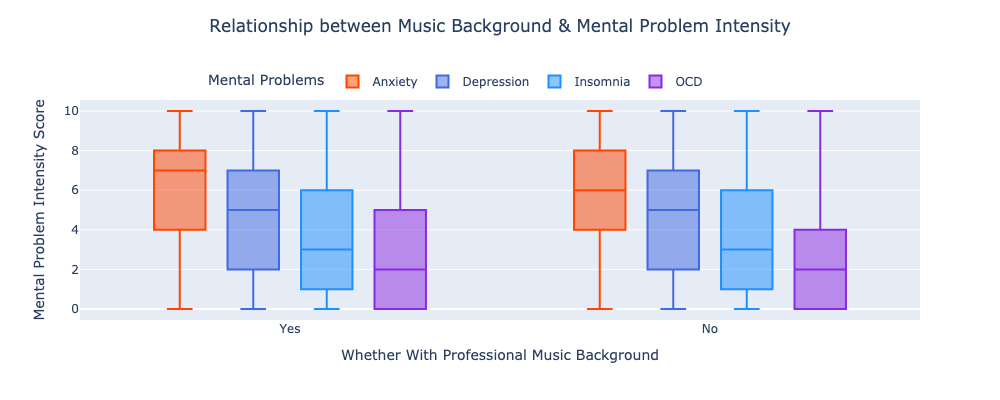

In [71]:
fig12 = go.Figure()

# Anxiety
fig12.add_trace(
    go.Box(
        x=survey['Pro'],
        y=survey['Anxiety'],
        marker_color='orangered',
        name='Anxiety')
)

# Depression
fig12.add_trace(
    go.Box(
        x=survey['Pro'],
        y=survey['Depression'],
        marker_color='royalblue',
        name='Depression')
)

# Insomnia
fig12.add_trace(
    go.Box(
        x=survey['Pro'],
        y=survey['Insomnia'],
        marker_color='dodgerblue',
        name='Insomnia')
)

# OCD
fig12.add_trace(
    go.Box(
        x=survey['Pro'],
        y=survey['OCD'],
        marker_color='blueviolet',
        name='OCD')
)


fig12.update_layout(
    width=1000, height=400,
    boxmode='group',
    xaxis_title='Whether With Professional Music Background',
    yaxis_title='Mental Problem Intensity Score',
    title_text='Relationship between Music Background & Mental Problem Intensity',
    title_x=0.5, title_y=0.95,
    legend=dict(title='Mental Problems', xanchor='left', x=0.15, yanchor='top', y=1.15, orientation='h')
)

fig12.show('png')

### Findings:

1. Responders WITH or WITHOUT professional musical background have the **same distribution** of intensity scores in **Depression and Insomnia**.


2. Responders **WITH** professional musical background have **higher median anxiety** intensity

    - WITH: median=7; WITHOUT: median=6
    

3. Responders **WITHOUT** professional musical background have **more concentrated lower OCD** intensity.

    - WITH: Q3=5; WITHOUT: Q3=4

## Correlation among different Mental Problems

- Trigger to explore: Responders may have **multiple mental problems at the same time** (e.g. an individual may have both anxiety and insomnia)


- Method: Plotted a **Correlation Heatmap** based on the correlation matrix of 4 mental problems.

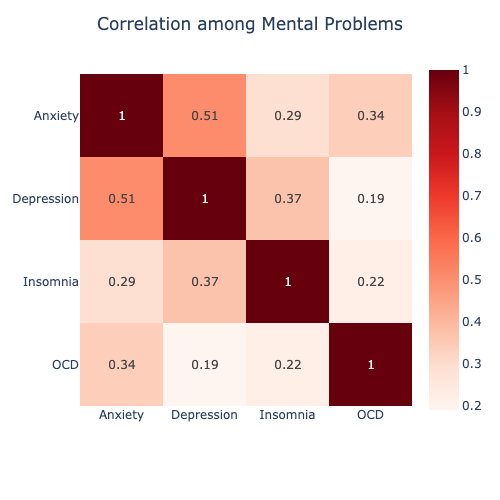

In [74]:
# create a correlation matrix
corr_mh = round(mental_problem.corr(), 2)
fig13 = px.imshow(corr_mh, text_auto=True, color_continuous_scale='Reds')
fig13.update_layout(
    width=500, height=500,
    title_text='Correlation among Mental Problems',
    title_x=0.5
)
fig13.show('png')

### Findings:

1. Overall: All these four mental problems show some **positive overlaps** with each other.


2. In detail: **Anxiety and Depression** shows the **strongest correlation** (0.51), probably because these **two disorders have similar symptoms**.


3. OCD seems to have a **relatively weak correlation** with other disorders. The most highly correlated problem with OCD is anxiety, as they may both be caused by **stress**.

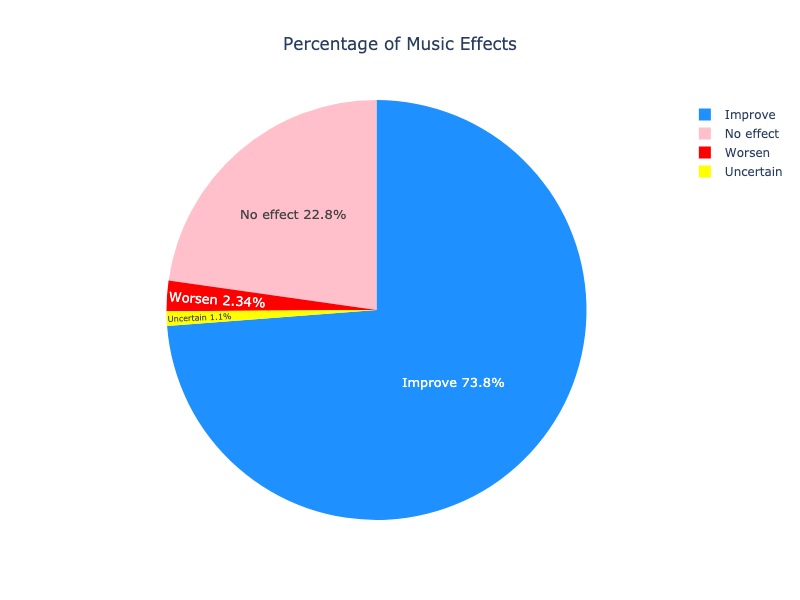

In [76]:
# Pie Chart for Music Effects
effect = survey['Music effects'].value_counts(normalize=True)

fig14=px.pie(
    effect,
    values=effect.values,
    names=effect.index, 
    title='Percentage of Music Effects',
    color_discrete_sequence=['dodgerblue', 'pink', 'red', 'yellow']
)

fig14.update_traces(
    textinfo="percent+label",
    textposition='inside',
    textfont_size=13,
    texttemplate="%{label} %{percent}"
)

fig14.update_layout(width=800,height=600, title_x=0.5)
fig14.show('png')

# Delve Deeper into Groups with Severe & Moderate Mental Problems

In [78]:
# divide into groups based on mental health problem
anxiety_group = survey[survey['Anxiety']>3]
depression_group= survey[survey['Depression']>3]
insomnia_group = survey[survey['Insomnia']>3]
ocd_group = survey[survey['OCD']>3]

## Group 1: Therapy Effect on *Anxiety* by Genre

In [80]:
'''Calculate number of people in each Effect group for each Genre'''
anxiety_effect_list = []

for g in survey['Fav genre'].unique().tolist():
    genre_effect = dict(anxiety_group[anxiety_group['Fav genre']==g].groupby('Music effects').size())
#     print(g, genre_effect)
    anxiety_effect_list.append([g, genre_effect])
anxiety_effect_df = pd.DataFrame(anxiety_effect_list, columns=['Genre', 'Therapy Effect'])

'''Expand column of a dictionary into 4 columns'''
anxiety_effect_df1= anxiety_effect_df['Therapy Effect'].apply(pd.Series)

# fill in NA with 0; modify data type into integer (num of people)
anxiety_effect_df1 = anxiety_effect_df1.fillna(0).astype(int)

# merge two dataframes; DROP 'Therapy Effect'
anxiety_effect_df2 = anxiety_effect_df.join(anxiety_effect_df1).drop('Therapy Effect', axis=1)

# calculate total number of people for each Genre
anxiety_effect_df2.insert(1, 'Sum', anxiety_effect_df2.iloc[:, 1:].sum(axis=1))

'''Feature Engineering: calculate percentage of each effect'''
anxiety_effect_df2['Improve_pct'] = round(anxiety_effect_df2['Improve']/anxiety_effect_df2['Sum']*100, 1)
anxiety_effect_df2['NoEffect_pct'] = round(anxiety_effect_df2['No effect']/anxiety_effect_df2['Sum']*100, 1)
anxiety_effect_df2['Uncertain_pct'] = round(anxiety_effect_df2['Uncertain']/anxiety_effect_df2['Sum']*100, 1)
anxiety_effect_df2['Worsen_pct'] = round(anxiety_effect_df2['Worsen']/anxiety_effect_df2['Sum']*100, 1)

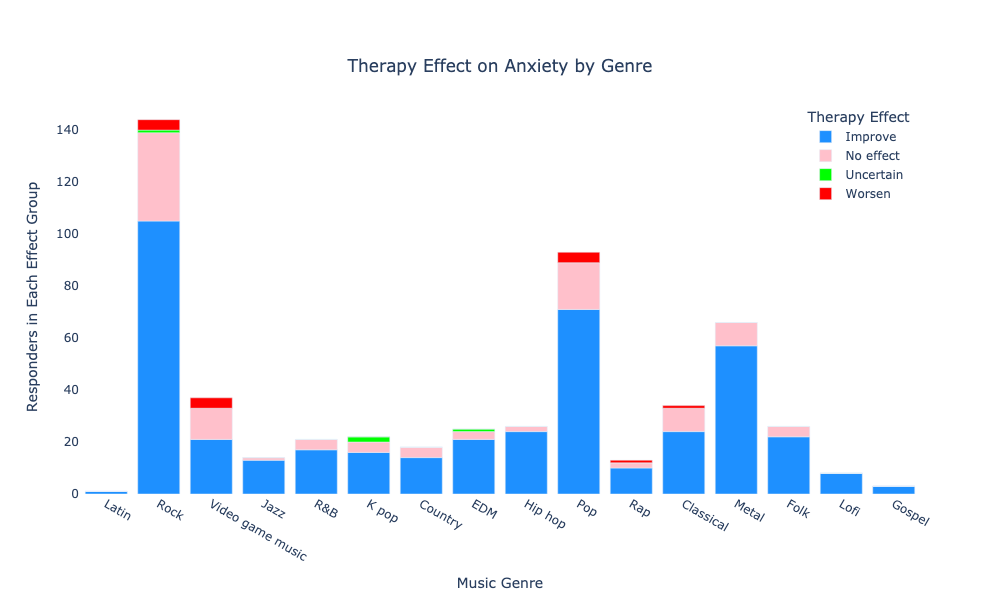

In [81]:
fig15 = px.bar(
    anxiety_effect_df2,
    x='Genre', y=['Improve', 'No effect', 'Uncertain', 'Worsen'],
    title='Therapy Effect on Anxiety by Genre',
    labels={'variable':'Therapy Effect'},
    color_discrete_sequence=['dodgerblue','pink','lime','red'],
    hover_data=['Worsen_pct', 'NoEffect_pct', 'Improve_pct']
)

fig15.update_layout(
    width=1000, height=600,
    title_x=0.5, title_y=0.9,
    xaxis_title='Music Genre',
    yaxis_title='Responders in Each Effect Group',
    legend=dict(xanchor='right', yanchor='top', x=0.99, y=0.99),
    plot_bgcolor='white'
)

fig15.show('png')

### Findings:

1. Music genres that may **worsen anxiety** during therapy: **Video game music (10.8%), Pop (4.3%), Rock (2.8%)**

    - Risky Genres that need to be further tested: Rap and Classical.


2. Music genres that should be **recommended to their fans** when healing anxiety: **Lofi (100% Improve)**.

    - Gospel and Latin have few observations (<=3), need to be tested more
    - Other genres considered: **Jazz, Hip hop <u/>(Over 90% listeners' anxiety intensity improved after therapy, while the others didn't worsen)**</u>


## Group 2: Therapy Effect on *Depression* by Genre

In [84]:
depression_effect_list= []
for g in survey['Fav genre'].unique().tolist():
    genre_effect = dict(depression_group[depression_group['Fav genre']==g].groupby('Music effects').size())
    depression_effect_list.append([g, genre_effect])

depression_effect_df = pd.DataFrame(depression_effect_list, columns=['Genre', 'Therapy Effect'])

depression_effect_df1= depression_effect_df['Therapy Effect'].apply(pd.Series)
depression_effect_df1 = depression_effect_df1.fillna(0).astype(int)
depression_effect_df2= depression_effect_df.join(depression_effect_df1).drop('Therapy Effect', axis=1)

# calculate total number of people for each Genre
depression_effect_df2.insert(1, 'Sum', depression_effect_df2.iloc[:, 1:].sum(axis=1))

'''Feature Engineering: calculate percentage of each effect'''
depression_effect_df2['Improve_pct'] = round(depression_effect_df2['Improve']/depression_effect_df2['Sum']*100, 1)
depression_effect_df2['NoEffect_pct'] = round(depression_effect_df2['No effect']/depression_effect_df2['Sum']*100, 1)
depression_effect_df2['Uncertain_pct'] = round(depression_effect_df2['Uncertain']/depression_effect_df2['Sum']*100, 1)
depression_effect_df2['Worsen_pct'] = round(depression_effect_df2['Worsen']/depression_effect_df2['Sum']*100, 1)

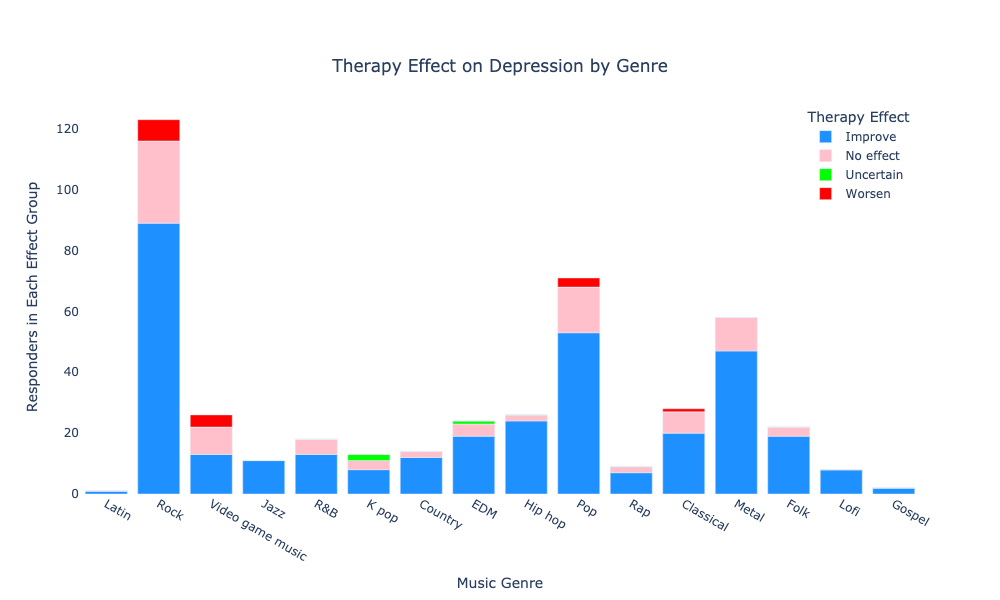

In [85]:
fig16 = px.bar(
    depression_effect_df2,
    x='Genre', y=['Improve', 'No effect', 'Uncertain', 'Worsen'],
    title='Therapy Effect on Depression by Genre',
    labels={'variable':'Therapy Effect'},
    color_discrete_sequence=['dodgerblue','pink','lime','red'],
    hover_data=['Worsen_pct', 'NoEffect_pct', 'Improve_pct']
)

fig16.update_layout(
    width=1000, height=600,
    title_x=0.5, title_y=0.9,
    xaxis_title='Music Genre',
    yaxis_title='Responders in Each Effect Group',
    legend=dict(xanchor='right', yanchor='top', x=0.99, y=0.99),
    plot_bgcolor='white'
)

fig16.show('png')

### Findings:

1. Music genres that may **worsen depression** during therapy: **Video game music (15.4%),  Rock (5.7%), Pop (4.2%)**

    - Risky Genres that need to be further tested: Classical.


2. Music genres that should be **recommended to their fans** when healing depression: **Lofi & Jazz (100% Improve)**.

    - Gospel and Latin have few observations (<=3), need to be tested more
    - Other genres considered: **Hip hop <u/>(Over 90% listeners' depression intensity improved after therapy, while the others didn't worsen)**</u>


## Group 3: Therapy Effect on *Insomnia* by Genre

In [88]:
insomnia_effect_list= []
for g in survey['Fav genre'].unique().tolist():
    genre_effect = dict(insomnia_group[insomnia_group['Fav genre']==g].groupby('Music effects').size())
    insomnia_effect_list.append([g, genre_effect])

insomnia_effect_df = pd.DataFrame(insomnia_effect_list, columns=['Genre', 'Therapy Effect'])

insomnia_effect_df1= insomnia_effect_df['Therapy Effect'].apply(pd.Series)
insomnia_effect_df1 = insomnia_effect_df1.fillna(0).astype(int)
insomnia_effect_df2= insomnia_effect_df.join(insomnia_effect_df1).drop('Therapy Effect', axis=1)

# calculate total number of people for each Genre
insomnia_effect_df2.insert(1, 'Sum', insomnia_effect_df2.iloc[:, 1:].sum(axis=1))

'''Feature Engineering: calculate percentage of each effect'''
insomnia_effect_df2['Improve_pct'] = round(insomnia_effect_df2['Improve']/insomnia_effect_df2['Sum']*100, 1)
insomnia_effect_df2['NoEffect_pct'] = round(insomnia_effect_df2['No effect']/insomnia_effect_df2['Sum']*100, 1)
insomnia_effect_df2['Uncertain_pct'] = round(insomnia_effect_df2['Uncertain']/insomnia_effect_df2['Sum']*100, 1)
insomnia_effect_df2['Worsen_pct'] = round(insomnia_effect_df2['Worsen']/insomnia_effect_df2['Sum']*100, 1)

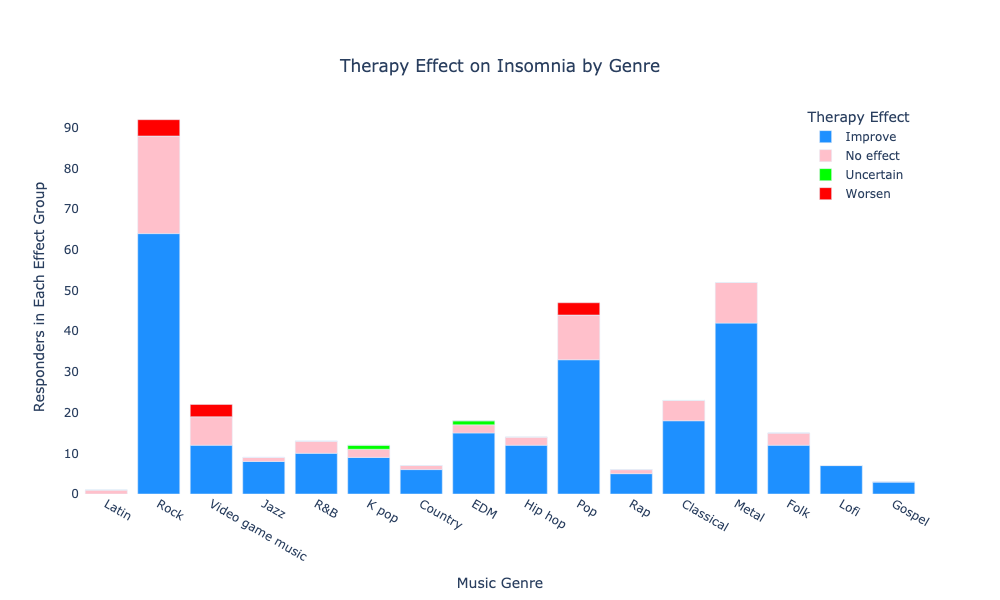

In [89]:
fig17 = px.bar(
    insomnia_effect_df2,
    x='Genre', y=['Improve', 'No effect', 'Uncertain', 'Worsen'],
    title='Therapy Effect on Insomnia by Genre',
    labels={'variable':'Therapy Effect'},
    color_discrete_sequence=['dodgerblue','pink','lime','red'],
    hover_data=['Worsen_pct', 'NoEffect_pct', 'Improve_pct']
)

fig17.update_layout(
    width=1000, height=600,
    title_x=0.5, title_y=0.9,
    xaxis_title='Music Genre',
    yaxis_title='Responders in Each Effect Group',
    legend=dict(xanchor='right', yanchor='top', x=0.99, y=0.99),
    plot_bgcolor='white'
)

fig17.show('png')

### Findings:

1. Music genres that may **worsen insomnia** during therapy: **Video game music (13.6%),  Pop (6.4%), Rock (4.3%)**


2. Music genres that should be **recommended to their fans** when healing depression: **Lofi (100% Improve)**.

    - Gospel has few observations (<=3), need to be tested more
    - Other genres considered: None. 
        - <u/>88.9% of Jazz listeners' insomnia intensity improved after therapy, less than 90% threshold, so no recommended genres in this part.</u>


## Group 4: Therapy Effect on *OCD* by Genre

In [92]:
ocd_effect_list= []
for g in survey['Fav genre'].unique().tolist():
    genre_effect = dict(ocd_group[ocd_group['Fav genre']==g].groupby('Music effects').size())
    ocd_effect_list.append([g, genre_effect])

ocd_effect_df = pd.DataFrame(ocd_effect_list, columns=['Genre', 'Therapy Effect'])

ocd_effect_df1= ocd_effect_df['Therapy Effect'].apply(pd.Series)
ocd_effect_df1 = ocd_effect_df1.fillna(0).astype(int)
ocd_effect_df2= ocd_effect_df.join(ocd_effect_df1).drop('Therapy Effect', axis=1)

# calculate total number of people for each Genre
ocd_effect_df2.insert(1, 'Sum', ocd_effect_df2.iloc[:, 1:].sum(axis=1))

ocd_effect_df2['Improve_pct'] = round(ocd_effect_df2['Improve']/ocd_effect_df2['Sum']*100, 1)
ocd_effect_df2['NoEffect_pct'] = round(ocd_effect_df2['No effect']/ocd_effect_df2['Sum']*100, 1)
ocd_effect_df2['Uncertain_pct'] = round(ocd_effect_df2['Uncertain']/ocd_effect_df2['Sum']*100, 1)
ocd_effect_df2['Worsen_pct'] = round(ocd_effect_df2['Worsen']/ocd_effect_df2['Sum']*100, 1)

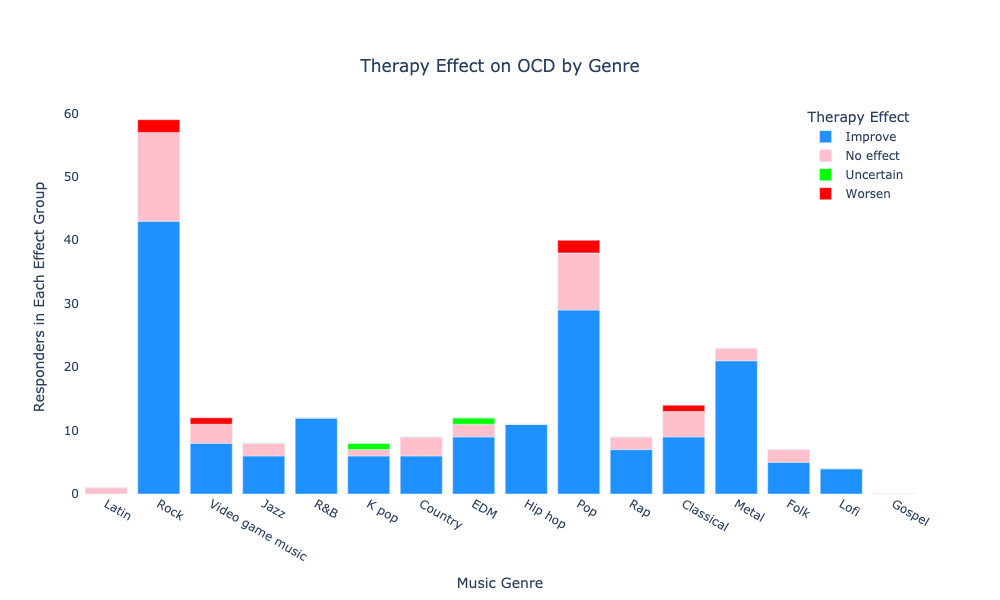

In [93]:
fig18 = px.bar(
    ocd_effect_df2,
    x='Genre', y=['Improve', 'No effect', 'Uncertain', 'Worsen'],
    title='Therapy Effect on OCD by Genre',
    labels={'variable':'Therapy Effect'},
    color_discrete_sequence=['dodgerblue','pink','lime','red'],
    hover_data = ['Worsen_pct', 'NoEffect_pct', 'Improve_pct']
)

fig18.update_layout(
    width=1000, height=600,
    title_x=0.5, title_y=0.9,
    xaxis_title='Music Genre',
    yaxis_title='Responders in Each Effect Group',
    legend=dict(xanchor='right', yanchor='top', x=0.99, y=0.99),
    plot_bgcolor='white'
)

fig18.show('png')

### Findings:

1. Music genres that may **worsen OCD** during therapy: **Pop (5%), Rock (3.4%)**

    - Risky Genres that need to be further tested: Video game music & Classical.


2. Music genres that should be **recommended to their fans** when healing depression: **Lofi, R&B, Hip hop (100% Improve)**.

    - Other genres considered: Metal
        - <u/>91.3% of Metal listeners' OCD intensity improved after therapy</u>


# Summary

## Data Information

1. Data Description: 736 data points from a public mental health survey, with respondents from diverse age ranges and regions.


2. Data Structure: The survey contained information of respondents including their general musical background and listening habits, frequency and preference for different music genres, and their mental health conditions (4 types: anxiety, depression, insomnia, obsessive compulsive disorder - OCD).

## Data Cleaning

1. **Missing Value Imputation** 

    - For *numerical* variables, **column means** were used to fill in NA.
    - For *categorical* variables, **column modes** were used.
    - For our major target response variable "Therapy Effect", we filled missing values with a **customized new label** "Uncertain".


2. **Remove Outliers**

    - **Checked distributions** of numerical variables to **detect outliers and abnormal observations** and then **drop outliers** in 'Age' and 'Listening Hour'.


3. **Standardize Data Formats**


## Feature Engineering

1. **Generate a new feature** 'Pro' to group respondents into professional musicians and non-professional listeners **by combining existed columns**


2. For each mental health problem, we **calculated the percentage of each therapy effect by genre** to **identify the most effective music genres** for healing that type of mental problem. For example, we found that Lofi would improve the condition of anxiety while Video Game music would probably worsen anxiety. 


## Exploratory Data Analysis

1. **Conducted bivariate analysis** to explore **the distribution of** age, listening hour and listening frequency **for each genre**.


2. Explored the **Overall intensity scores of mental problems** for responders as well as the **mental condition for listeners in each genre**, and **compared among 4 mental problems** <u/>to see whether listeners who favor a specific music genre would have specific mental problems</u>. 
    - For example, responders who prefer Rap generally have comparably lower intensity of insomnia
    
    
3. Checked the Relationship between Mental Problem Intensity and professional musical background.
    - For example, responders WITH professional musical background have higher median anxiety intensity, while non-professional listeners have lower OCD intensity.
    
    
4. **Performed Correlation Analysis** among 4 mental problems by creating a **correlation heatmap**, and detected overlaps among these problems. 
    - Key Finding: Anxiety and Depression shows the strongest correlation


5. **Explored the distribution of Therapy Effects** and found that 73.8% responders benefits from music therapy, while 22.8% reponsders feel unchanged. This indicates the **generally positive effect** of using music for mental therapy. We could *suggest proper genres* for those responders with "no effect" in current stage and double check the therapy effect.


## Output

1. Applied **Plotly** to generate **interactive data visualizations** including **grouped bar charts**, **line charts**, **pie charts**, **box plots** and **heatmaps** to show our findings.